In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


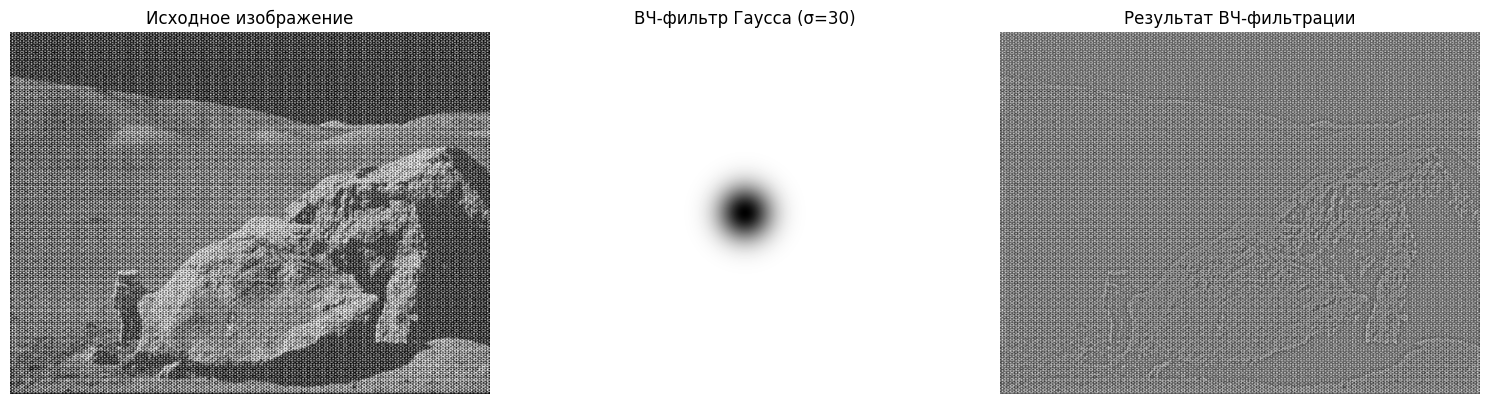

In [2]:
img = cv2.imread('periodic_noise.JPG', cv2.IMREAD_GRAYSCALE)

def gaussian_highpass_filter(shape, sigma):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    u = np.arange(rows)
    v = np.arange(cols)
    u, v = np.meshgrid(u, v, indexing='ij')

    d = np.sqrt((u - crow)**2 + (v - ccol)**2)
    
    h = 1 - np.exp(-(d**2) / (2 * (sigma**2)))
    return h

fft_image = np.fft.fft2(img)
sigma = 30
hp_filter = gaussian_highpass_filter(img.shape, sigma)
fft_shifted = np.fft.fftshift(fft_image)
filtered_fft = fft_shifted * hp_filter
filtered_image = np.real(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))
filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hp_filter, cmap='gray')
plt.title('ВЧ-фильтр Гаусса (σ=30)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(filtered_image, cmap='gray')
plt.title('Результат ВЧ-фильтрации')
plt.axis('off')

plt.tight_layout()
plt.show()

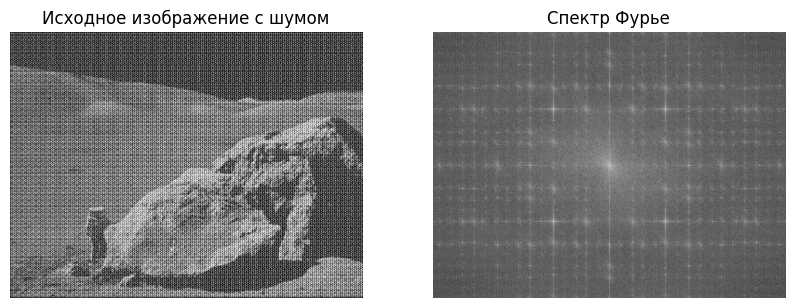

In [3]:
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение с шумом')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Спектр Фурье')
plt.axis('off')
plt.show()

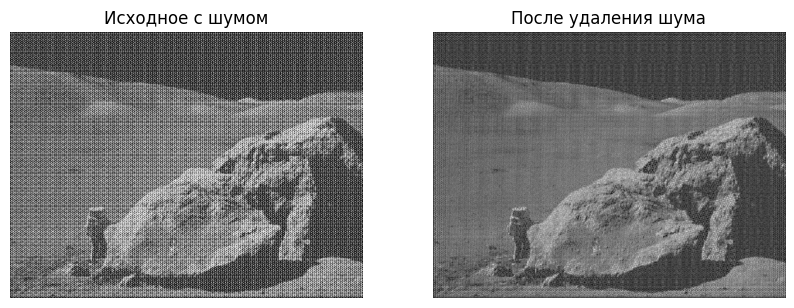

In [4]:
from skimage.feature import peak_local_max

local_maxima = peak_local_max(magnitude_spectrum, min_distance=20, threshold_abs=180)

rows, cols = img.shape
mask = np.ones((rows, cols, 2), dtype=np.float32)
center_x, center_y = rows//2, cols//2

for peak in local_maxima:
    y, x = peak
    distance = np.sqrt((x - center_y)**2 + (y - center_x)**2)
    if distance > 40:  
        cv2.circle(mask, (x, y), 5, (0, 0), -1)

dft_shift_filtered = dft_shift * mask

f_ishift = np.fft.ifftshift(dft_shift_filtered)
image_idft = cv2.idft(f_ishift)
image_idft = cv2.magnitude(image_idft[:,:,0], image_idft[:,:,1])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное с шумом')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_idft, cmap='gray')
plt.title('После удаления шума')
plt.axis('off')
plt.show()